# TRes Anomaly Detector

An anomaly detection algorithm that uses studentized residuals to find outliers. 

Contents:
* [Generating Toy Data Set](#generating-toy-data-set)
* [Reference Anomaly Detection](#Reference-Anomaly-Detection)
* [Studentized Residuals: the hard way](#studentized-residuals:-the-hard-way)
* [Studentized Residuals: the fast way!](#studentized-residuals:-the-fast-way!)
* [Choosing the right threshold: the Bonferroni critical value](#choosing-the-right-threshold:-the-bonferroni-critical-value)

## Generating Toy Data Set

Generating a polynomial curve with added Gaussian noise. Additionally, we will add some anomalous points that need to be removed by our algorithm. 

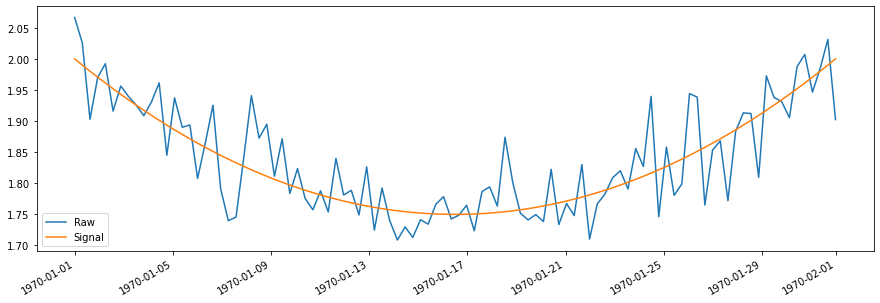

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create test data
np.random.seed(10)
nx = 100
x = np.linspace(0, 10, nx)
x_dt = pd.date_range(start="1970", periods=nx, end="02-01-1970")

y_hat = 1e-2 * x ** 2 - 1e-1 * x + 2

y_tilda = np.random.normal(size=nx, scale=0.05)

y = y_hat + y_tilda

data = pd.Series(y, index=x_dt)
perfect_data = pd.Series(y_hat, index=x_dt)

data.plot(figsize=(15,5))
perfect_data.plot()
plt.legend(['Raw','Signal'])

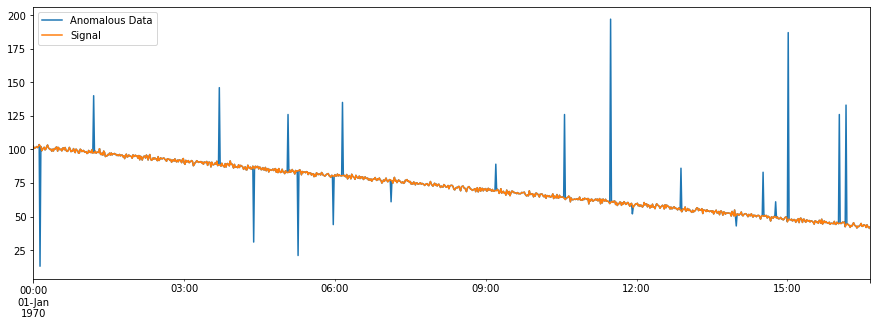

In [42]:
size = 1000

y_hat = 1e-10 * x ** 2 - 1e-3 * x + 2

sig = np.random.normal(loc=100, size=size, scale=1) +y_hat
index = pd.date_range(start="1970", periods=size, freq="1T")

# Add anomalies
anom_num = [61, 61, 126, 83, 133, 21, 126, 126, 187, 13, 86, 140, 44, 146, 89, 135, 52, 31, 43, 197]
anom_ids = [886, 427, 304, 871, 970, 316, 962, 634, 901, 8, 773, 72, 358, 222, 552, 369, 715, 263, 839, 689]

sig[anom_ids] = anom_num

clean_sig = np.delete(sig, anom_ids)

anomalous_data = pd.Series(sig, index=index)
clean_data = pd.Series(clean_sig, index=np.delete(index, anom_ids))

anomalous_data.plot(figsize=(15,5))
clean_data.plot()
plt.legend(['Anomalous Data', 'Signal'])

## Reference Anomaly Detection

Typical linear regression with thresholding

20
980


1000

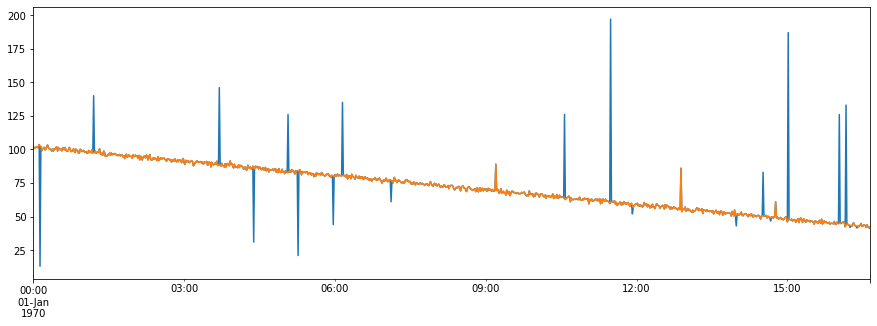

In [44]:
# Convert datetime index to integers
data=anomalous_data
alpha=1.0

poly_order = 2
x = (np.array(data.index, dtype=np.int64) - data.index[0].value) / 1e9
y = data.to_numpy()  # Just to please pandas devs

# Create a polynomial fit and apply the fit to data
coefs = np.polyfit(x, y, poly_order)
y_pred = np.polyval(coefs, x)

# Find residuals
res = (y - y_pred)
threshold_high = np.percentile(res,alpha)
threshold_low = np.percentile(res,100-alpha)

# Mask (true if either condition is true (i.e res does NOT exceeds either threshold))
mask = np.logical_and(res >= threshold_high, res <= threshold_low)

# Plot anomalous data and filtered data
ax=anomalous_data.plot(figsize=(15,5))
anomalous_data[mask].plot(ax=ax)

print(len(anom_ids))
print(len(anomalous_data[mask]))
len(anomalous_data)

## Studentized Residuals: the hard way

Iterating through each datapoint and refitting the polynomial curve

20
980


1000

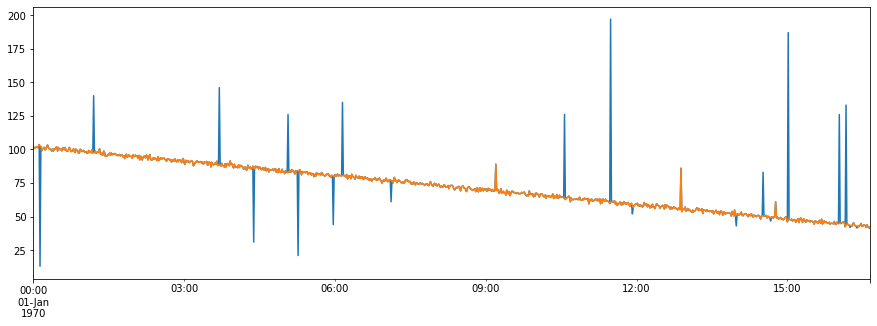

In [45]:
# Convert datetime index to integers
data=anomalous_data
alpha=1.0


store=[]
for item in range(len(data)):
    to_drop = data.index[item]
    tmp = data.drop(to_drop)
    
    poly_order = 3
    real_x = (np.array(data.index, dtype=np.int64) - data.index[0].value) / 1e9
    real_y = data.to_numpy()
    
    x = (np.array(tmp.index, dtype=np.int64) - tmp.index[0].value) / 1e9
    y = tmp.to_numpy()  # Just to please pandas devs

    # Create a polynomial fit and apply the fit to data
    coefs = np.polyfit(x, y, poly_order)
    y_pred = np.polyval(coefs, real_x)

    # Find residuals
    res = (real_y[item] - y_pred[item])
    store.append(res)

threshold_high = np.percentile(store,alpha)
threshold_low = np.percentile(store,100-alpha)

# Mask (true if either condition is true (i.e res does NOT exceeds either threshold))
mask = np.logical_and(store >= threshold_high, store <= threshold_low)

# Plot anomalous data and filtered data
ax=anomalous_data.plot(figsize=(15,5))
anomalous_data[mask].plot(ax=ax)

print(len(anom_ids))
print(len(anomalous_data[mask]))
len(anomalous_data)

## Studentized Residuals: the fast way!

We don't need to refit the curve everytime if we use the Hat matrix (otherwise known as the Projection matrix)

20
980


1000

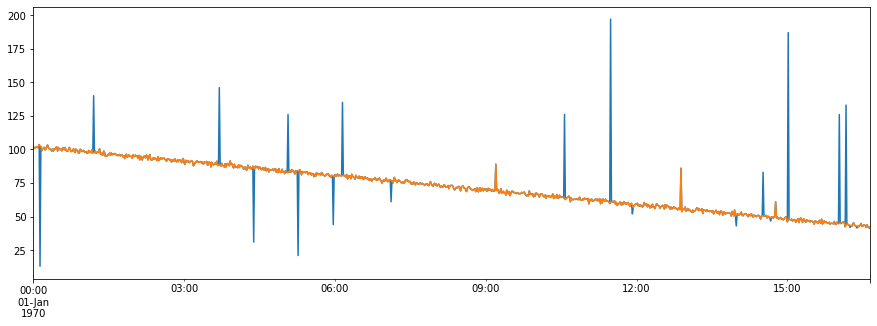

In [46]:

from scipy.stats import t as student_dist


# Convert datetime index to integers
data=anomalous_data
alpha=1.0

poly_order = 2


poly_order = 2
x = (np.array(data.index, dtype=np.int64) - data.index[0].value) / 1e9
y = data.to_numpy()  # Just to please pandas devs

# Create a polynomial fit and apply the fit to data
coefs = np.polyfit(x, y, poly_order)
y_pred = np.polyval(coefs, x)


# Calculate hat matrix
X_mat = np.vstack((np.ones_like(x), x)).T
X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
hat_diagonal = X_hat.diagonal()

# Calculate degrees of freedom
n = len(y)
dof = n - 3  # Using p = 2 from paper

# Determine the residuals and standardise them
res = y - y_pred

threshold_high = np.percentile(res,alpha)
threshold_low = np.percentile(res,100-alpha)

# Mask (true if either condition is true (i.e res does NOT exceeds either threshold))
mask = np.logical_and(res >= threshold_high, res <= threshold_low)

# Plot anomalous data and filtered data
ax=anomalous_data.plot(figsize=(15,5))
anomalous_data[mask].plot(ax=ax)

print(len(anom_ids))
print(len(anomalous_data[mask]))
len(anomalous_data)


In [16]:
len(data)

1000

## Choosing the right threshold: the Bonferroni critical value

Choosing the right value can be tricky without trial and error especially if we want to generalise the algorithm to deal with any curve. 

20
981


1000

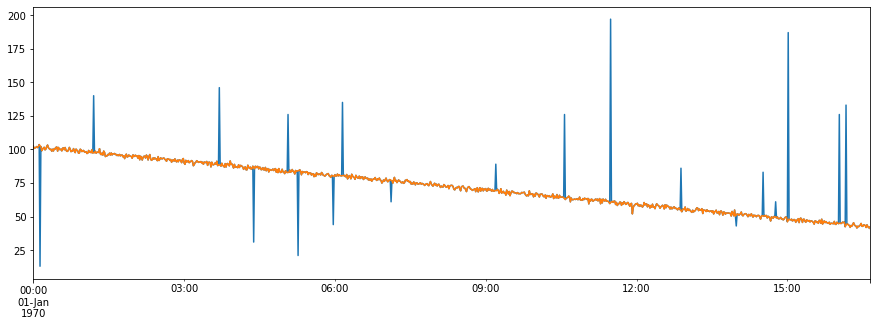

In [47]:
from scipy.stats import t as student_dist


# Convert datetime index to integers
data=anomalous_data
alpha=0.05

poly_order = 2
bc_relaxation: float = 1.0

poly_order = 2
x = (np.array(data.index, dtype=np.int64) - data.index[0].value) / 1e9
y = data.to_numpy()  # Just to please pandas devs

# Create a polynomial fit and apply the fit to data
coefs = np.polyfit(x, y, poly_order)
y_pred = np.polyval(coefs, x)


# Calculate hat matrix
X_mat = np.vstack((np.ones_like(x), x)).T
X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
hat_diagonal = X_hat.diagonal()

# Calculate degrees of freedom
n = len(y)
dof = n - 3  # Using p = 2 from paper

# Determine the residuals and standardise them
res = y - y_pred

sse = np.sum(res ** 2)
t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res))

# Return p values from Student distribution and calculate Bonferroni critical value
p_vals = student_dist.sf(t_res, df=dof)
bc = student_dist.sf(1 - alpha / (2 * n), df=dof) * bc_relaxation

# Return filtered dataframe with the anomalies removed
mask = np.logical_and(p_vals >= bc, p_vals <= (1 - bc))

# Plot anomalous data and filtered data
ax=anomalous_data.plot(figsize=(15,5))
anomalous_data[mask].plot(ax=ax)

print(len(anom_ids))
print(len(anomalous_data[mask]))
len(anomalous_data)